In [124]:
%pip install langgraph langchain langchain_openai langchain_community
%pip install -q langfuse

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [125]:
import os, getpass
import json

from typing import TypedDict, List, Optional, Dict, Any
from IPython.display import Image, display

from langfuse import Langfuse
from langfuse.callback import CallbackHandler

from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage

In [126]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env("LANGFUSE_PUBLIC_KEY")
_set_env("LANGFUSE_SECRET_KEY")
_set_env("LANGFUSE_HOST")

langfuse = Langfuse(
  secret_key=os.environ["LANGFUSE_SECRET_KEY"],
  public_key=os.environ["LANGFUSE_PUBLIC_KEY"],
  host=os.environ["LANGFUSE_HOST"]
)

langfuse_handler = CallbackHandler()

In [127]:
class Draft(TypedDict):
    title: str
    body: str
    images: List[str]

class Source(TypedDict):
    title: str
    url: str
    content: str
    score: float
    valid: bool
    reason: Optional[str]

class State(MessagesState):
    prompt: str
    topic: str
    sources: Optional[List[Source]]
    draft: str

In [128]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.7,
    streaming=True,
    verbose=True,
    callbacks=[langfuse_handler],
)

tavily = TavilySearchResults(max_results=5)

In [129]:
def get_user_prompt_node(state: State) -> State:
    '''
    Get the user prompt node.
    '''
    prompt = input(
        "Inserisci il prompt per l'articolo: "
    )
    return { "prompt": prompt }

In [130]:
def extract_topic_node(state: State) -> State:
    '''
    Extract the topic from the user prompt.
    '''
    
    prompt = f'''
    The user provided the following input:

    "{state["prompt"]}"
    Your task is to extract the main topic of the article that the user wants to write.
    The topic should be a single word or a short phrase that summarizes the main idea of the article.

    For example, if the user prompt is "How to train a dog", the topic would be "dog training".

    If the user prompt is "The history of the internet", the topic would be "internet history".

    Only return the topic.
    '''

    print(f"Prompt: {prompt}")

    response = llm.invoke(prompt)

    print(f"Response: {response}")
    
    topic = response.content.strip()
    return { "topic": topic }

In [131]:
def search_sources_node(state: State) -> State:
    '''
    Use Tavily to search for high-quality sources based on the topic.
    Filters results with score > 0.7 and keeps structured data.
    '''
    
    results = tavily.invoke({ "query": state["topic"] })

    formatted_results: List[Source] = [
        Source(
            title=r.get("title", ""),
            url=r.get("url", ""),
            content=r.get("content", ""),
            score=r.get("score", 0),
            valid=r.get("score", 0) > 0.7,
            reason=None
        )
        for r in results if r.get("score", 0) > 0.7
    ]

    return { "sources": formatted_results }

In [132]:
def generate_draft_node(state: State) -> State:
    '''
    Generate a draft for the article based on the topic and sources.
    '''

    urls = [source["url"] for source in state["sources"] if source["url"]]
    sources = "\n".join(urls)
    
    prompt = f'''
    Write a detailed article about the topic: "{state["topic"]}". 

    Use **ONLY** the exact information contained in the following sources, and do not add anything that is not directly supported by them. 
    The article should strictly reflect the facts as they are presented in the sources without any additional assumptions or unverified details:
    {sources}

    Make sure to mention the exact dates and details from the sources, without adding any speculative or external information. 
    The tone should be formal, informative, and objective.
    '''

    response = llm.invoke(prompt)
    draft = response.content.strip()
    return { "draft": draft }

In [133]:
def verify_sources_node(state: State) -> State:
    '''
    Use the LLM to verify the quality and reliability of each source based on its content and URL.
    For each source, return if it is reliable and usable for writing the article, and if not, provide a reason why.
    '''
    
    sources = state["sources"]
    
    verified_sources = []
    for source in sources:
        url = source["url"]
        content = source["content"]
        
        prompt = f'''
        You are a reliability and fact-checking assistant. Below is a source with its content:

        URL: {url}
        Content: {content}

        Question: Based on the content and the URL, is this source reliable and usable for writing an article? 
        Please provide a "YES" or "NO" answer. If "NO", explain why it is not reliable or usable.

        Use the following format:
        Reliable: <YES/NO>
        Explanation: <explanation>
        
        For example:
        Reliable: YES
        Explanation: The source is from a reputable news outlet and provides well-cited information. The content is well-researched and aligns with known facts.
        '''
        
        response = llm.invoke(prompt)
        result = response.content.strip()

        try:
            reliable_line = next(line for line in result.split("\n") if line.startswith("Reliable:"))
            explanation_line = next(line for line in result.split("\n") if line.startswith("Explanation:"))

            reliable = "YES" in reliable_line
            explanation = explanation_line.split(":")[1].strip()

        except StopIteration:
            reliable = False
            explanation = "Failed to extract reliable information from the source."

        verified_sources.append({
            "title": source["title"],
            "url": url,
            "content": content,
            "reliable": reliable,
            "reason": explanation if not reliable else None,
        })

    print("Verified sources: ")
    for source in verified_sources:
        print(f"Title: {source['title']}, Reliable: {source['reliable']}, Reason: {source['reason']}")
        
    usable_sources = [source for source in verified_sources if source["reliable"]]
    
    return { "sources": usable_sources }

In [135]:
builder = StateGraph(State)
builder.add_node("get_user_prompt", get_user_prompt_node)
builder.add_node("extract_topic", extract_topic_node)
builder.add_node("search_sources", search_sources_node)
builder.add_node("verify_sources", verify_sources_node)
builder.add_node("generate_draft", generate_draft_node)

builder.add_edge(START, "get_user_prompt")
builder.add_edge("get_user_prompt", "extract_topic")
builder.add_edge("extract_topic", "search_sources")
builder.add_edge("search_sources", "verify_sources")
builder.add_edge("verify_sources", "generate_draft")
builder.add_edge("generate_draft", END)

graph = builder.compile().with_config(
    callbacks=[langfuse_handler],
)

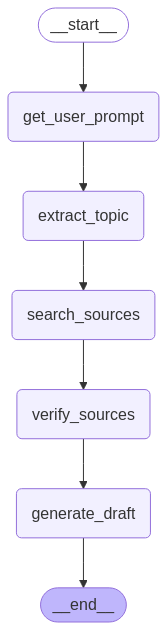

In [136]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [137]:
graph.invoke({})

Prompt: 
    The user provided the following input:

    "Scrivi un articolo sulla morte di papa Francesco"
    Your task is to extract the main topic of the article that the user wants to write.
    The topic should be a single word or a short phrase that summarizes the main idea of the article.

    For example, if the user prompt is "How to train a dog", the topic would be "dog training".

    If the user prompt is "The history of the internet", the topic would be "internet history".

    Only return the topic.
    
Response: content='morte di papa Francesco' additional_kwargs={} response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_129a36352a'} id='run-b8542c80-13ce-43e3-a46a-171913fa2b84-0'
Verified sources: 
Title: Morte di Papa Francesco - Wikipedia, Reliable: False, Reason: The content describes events that have not yet occurred as of my last training cut-off in October 2023. It mentions the death of Pope Francis in April 

{'messages': [],
 'prompt': 'Scrivi un articolo sulla morte di papa Francesco',
 'topic': 'morte di papa Francesco',
 'sources': [{'title': 'La morte di Papa Francesco, il feretro è a Santa Marta - Rai News',
   'url': 'https://www.rainews.it/maratona/2025/02/morto-papa-francesco-jorge-mario-bergoglio-la-malattia-le-ultime-ore-il-cordoglio-del-mondo-aggiornamenti-in-diretta-9a9892a5-e462-4789-859a-745ce4cc4989.html',
   'content': '"Con la morte di Papa Francesco, la Chiesa perde un grande Papa, un pastore prudente e un coraggioso rinnovatore della missione della Chiesa. Con profondo dolore, ci inchiniamo davanti a un Papa che si è preoccupato di stare tra la gente e di raggiungere i margini della società". Così il presidente della Conferenza Episcopale Tedesca, il vescovo Georg Bätzing, sulla morte di Papa Francesco, scomparso oggi all\'età di 88 anni. "Papa Francesco ha posto forti accenti nella Chiesa e ha inaugurato [...] Le indiscrezioni parlano di emorragia cerebrale, ma la causa